In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## *Importing and Distributing Data*

In [2]:
musics = pd.read_csv('TASK2_dataset.csv')
print(musics.head())


key1 = list(set(musics.keyword_1))
key2 = musics.keyword_2.unique()
key3 = musics.keyword_3.unique()

count = len(musics.genre)

   song_id keyword_1  keyword_2  keyword_3      genre
0       74    guitar      happy  distorted       rock
1      103     brass  energetic    melodic  classical
2      201     banjo      happy   acoustic    country
3      194     synth  energetic      heavy    hip-hop
4      184     synth  energetic       slow    hip-hop


# *Vectorisation*

## BOW

In [3]:
key_BOW_1 = np.zeros((count,len(key1)))
key_BOW_2 = np.zeros((count,len(key2)))
key_BOW_3 = np.zeros((count,len(key3)))


for i in range(count):
    for j in range(len(key1)):
        if key1[j] in musics.keyword_1[i]:
            key_BOW_1[i][j] += 1
    
    for j in range(len(key2)):
        if key2[j] in musics.keyword_2[i]:
            key_BOW_2[i][j] += 1
    
    for j in range(len(key3)):
        if key3[j] in musics.keyword_3[i]:
            key_BOW_3[i][j] += 1
            

## TF-IDF

In [4]:
tf_1 = np.copy(key_BOW_1)/3
tf_2 = np.copy(key_BOW_2)/3
tf_3 = np.copy(key_BOW_3)/3

idf_1 = np.zeros(len(key1))
idf_2 = np.zeros(len(key2))
idf_3 = np.zeros(len(key3))

for i in range(len(key1)):
    idf_1[i] = np.log((count+1)/sum(tf_1[:,i]+1))
for i in range(len(key2)):
    idf_2[i] = np.log((count+1)/sum(tf_2[:,i]+1))
for i in range(len(key3)):
    idf_3[i] = np.log((count+1)/sum(tf_3[:,i]+1))
    
tfidf_1 = tf_1 * idf_1
tfidf_2 = tf_2 * idf_2
tfidf_3 = tf_3 * idf_3

# *PCA*

In [5]:
def pca(set):
    temp = set - np.mean(set)
    temp = temp / np.std(temp)
    
    temp = np.cov (temp.T)
    
    eigenval , eigenvect = np.linalg.eig(temp)
    
    index = np.argsort(eigenval)[::-1]
    eigenvect = eigenvect[:,index[0:2]]
    
    temp = set @ eigenvect
    
    return temp
    
    

pca_1 = pca(tfidf_1)
pca_2 = pca(tfidf_2)
pca_3 = pca(tfidf_3)
pcas = np.zeros(pca_1.shape)

pcas =  np.cbrt(pca_1**10 + pca_2**10 + pca_3**10)
    

# *K-Means*

In [6]:
np.random.seed(100)  

cents = 10
centroids = pcas[np.random.choice(range(len(pcas)),cents , replace=False)]

for i in range(100):
    distances = np.linalg.norm(pcas[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    new_centroids = np.array([pcas[labels == j].mean(axis=0) for j in range(cents)])

    centroids = new_centroids

# Plot of the PCA distribution

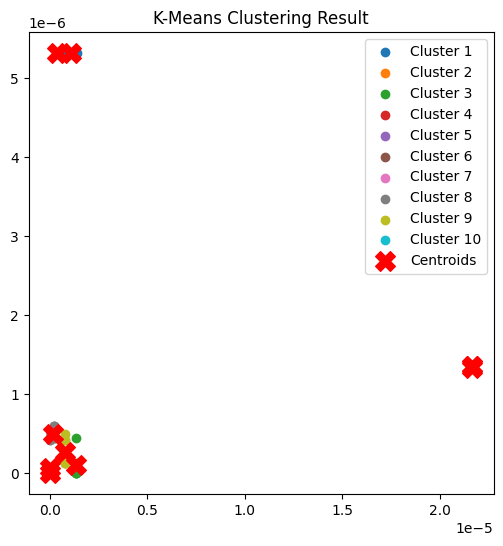

In [7]:
plt.figure(figsize=(6,6))
for i in range(cents):
    plt.scatter(pcas[labels == i][:, 0], pcas[labels == i][:, 1], label=f"Cluster {i+1}")
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', s=200, label="Centroids")
plt.legend()
plt.title("K-Means Clustering Result")
plt.show()

# Distribution table for clusters and genre

In [8]:
musics["Cluster"] = labels  


genre_distribution = musics.groupby(["Cluster", "genre"]).size().unstack().fillna(0)


genre_distribution = genre_distribution.div(genre_distribution.sum(axis=1), axis=0) * 100


print(genre_distribution)

genre    classical    country    hip-hop        pop       rock
Cluster                                                       
0         0.000000   0.000000  62.500000  37.500000   0.000000
1         0.000000  42.857143   0.000000   7.142857  50.000000
2        75.000000  12.500000   0.000000  12.500000   0.000000
3         0.000000  32.258065   0.000000  19.354839  48.387097
4        40.000000  40.000000   0.000000  20.000000   0.000000
5         0.000000  35.000000   0.000000  25.000000  40.000000
6        50.000000  16.666667   0.000000  33.333333   0.000000
7        76.923077   7.692308   0.000000  15.384615   0.000000
8        85.714286  14.285714   0.000000   0.000000   0.000000
9         0.000000   0.000000  74.074074  25.925926   0.000000


Checking for S

In [9]:
X = pcas
n = X.shape[0]
unique_clusters = np.unique(labels)  

a_values = np.zeros(n)  

for i in range(n):
    own_cluster = labels[i]
    own_cluster_points = X[labels == own_cluster] 
    
    if len(own_cluster_points) > 1:
        distances = [np.linalg.norm(X[i] - p) for p in own_cluster_points if not np.array_equal(X[i], p)]
        a_values[i] = np.mean(distances) 
    else:
        a_values[i] = 0 

b_values = np.zeros(n)

for i in range(n):
    own_cluster = labels[i]
    min_cluster_distance = float('inf')

    for cluster in unique_clusters:
        if cluster == own_cluster:
            continue  

        other_cluster_points = X[labels == cluster]
        mean_distance = np.mean([np.linalg.norm(X[i] - p) for p in other_cluster_points])
        min_cluster_distance = min(min_cluster_distance, mean_distance)  

    b_values[i] = min_cluster_distance


silhouette_scores = np.zeros(n)

for i in range(n):
    silhouette_scores[i] = (b_values[i] - a_values[i]) / max(a_values[i], b_values[i])

silhouette_score = np.mean(silhouette_scores)

print("Silhouette Score:", silhouette_score)


Silhouette Score: 0.7827249847882336
